<a href="https://colab.research.google.com/github/chaeyun22/Deeplearning-Project/blob/main/Multi_label_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torchvision.transforms as transforms
from torch.utils.data import Dataset, random_split, Subset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
import re
import os
import random
import torch.nn.functional as F
from sklearn.metrics import multilabel_confusion_matrix
from PIL import Image

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.0.1+cu118
Torchvision Version:  0.15.2+cu118


## (Multi-label) Custom Dataset Class 구현

In [3]:
!ls "/content/drive/MyDrive/garbage_images"

cardboard  glass  metal  paper	plastic  trash


In [4]:
class_labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [5]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [6]:
def to_device(data, device): # Move tensor(s) to chosen device
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [7]:
def denorm(img_tensors): # denormalize the tensors
    return img_tensors * imagenet_stats[1][0] + imagenet_stats[0][0]

In [8]:
# Multi-label image의 class들을 shape (6)의 Tensor로 Encoding
def encode_label(label, classes_list = class_labels):
    target = torch.zeros(len(class_labels))
    for l in label:
      idx = classes_list.index(l)
      target[idx] = 1
    return target

# 0과 1 형태의 Prediciton Tensor를 text 형태로 Decoding
def decode_target(target, threshold=0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
          result.append(class_labels[i])
    return ' '.join(result)

In [9]:
def show_example(img,label):
  plt.imshow(denorm(img).permute(1,2,0))
  print("Label:", decode_target(label))
  print()
  print(label)

In [10]:
# root_dir 입력 시 하위에 있는 image들의 전체 path를 가진 list를 리턴함
def get_path_names(dir):
  images = []
  for path, subdirs, files in os.walk(data_dir):
    for name in files:
      #print(os.path.join(path, name))
      images.append(os.path.join(path, name))
  return images

In [13]:
# Multi-label dataset 경로
data_dir = "/content/drive/MyDrive/dataset_merged"

In [14]:
len(get_path_names(data_dir)) # Multi-label images 개수

5000

In [15]:
class myDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.root_dir = root_dir
        self.images = get_path_names(root_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = Image.open(img_path)

        if self.transform:
            img = self.transform(img)

        label = img_path.split('/')[-1].split('_')[0].split('+')

        return img, encode_label(label)

In [16]:
# 기본
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

multi_label_dataset = myDataset(data_dir, transform = transform)
len(multi_label_dataset)

5000

In [17]:
# 2개의 labels가 나오는 것을 확인할 수 있음
multi_label_dataset[1]

(tensor([[[1.6667, 1.6667, 1.6324,  ..., 1.7694, 1.7523, 1.7523],
          [1.6667, 1.6667, 1.6153,  ..., 1.7694, 1.7523, 1.7523],
          [1.6667, 1.6495, 1.5810,  ..., 1.7694, 1.7523, 1.7523],
          ...,
          [1.7180, 1.6838, 1.6495,  ..., 0.9988, 0.9817, 0.9817],
          [1.7180, 1.6838, 1.6495,  ..., 0.9988, 0.9817, 0.9646],
          [1.7180, 1.6838, 1.6495,  ..., 0.9988, 0.9817, 0.9646]],
 
         [[1.8333, 1.8333, 1.7983,  ..., 1.7283, 1.7108, 1.7108],
          [1.8333, 1.8333, 1.7808,  ..., 1.7283, 1.7108, 1.7108],
          [1.8333, 1.8158, 1.7458,  ..., 1.7283, 1.7108, 1.7108],
          ...,
          [1.8859, 1.8508, 1.8158,  ..., 0.9405, 0.9230, 0.9230],
          [1.8859, 1.8508, 1.8158,  ..., 0.9405, 0.9230, 0.9055],
          [1.8859, 1.8508, 1.8158,  ..., 0.9405, 0.9230, 0.9055]],
 
         [[2.0823, 2.0823, 2.0474,  ..., 1.6988, 1.6814, 1.6814],
          [2.0823, 2.0823, 2.0300,  ..., 1.6988, 1.6814, 1.6814],
          [2.0823, 2.0648, 1.9951,  ...,

Label: cardboard plastic

tensor([1., 0., 0., 0., 1., 0.])


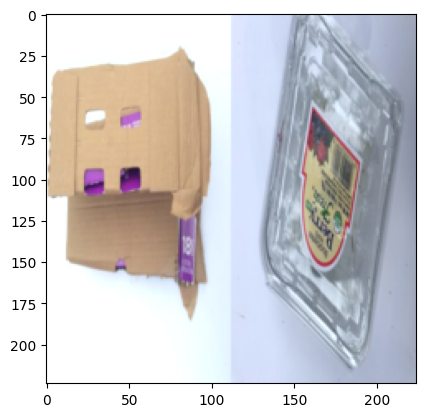

In [18]:
show_example(*multi_label_dataset[2782])

### train, valid, test split

In [19]:
num_data = len(multi_label_dataset)
indices = list(range(num_data))

split_ratio = [0.6, 0.2, 0.2]  # train, test, valid 데이터셋의 비율

random.shuffle(indices)  # 인덱스를 무작위로 섞음

train_split = int(num_data * split_ratio[0])
test_split = int(num_data * (split_ratio[0] + split_ratio[1]))

train_indices = indices[:train_split]
test_indices = indices[train_split:test_split]
valid_indices = indices[test_split:]

# Subset을 사용하여 train, test, valid 데이터셋 생성
train_dataset = Subset(multi_label_dataset, train_indices)
test_dataset = Subset(multi_label_dataset, test_indices)
valid_dataset = Subset(multi_label_dataset, valid_indices)

# 데이터로더 생성
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [20]:
for xb, yb in train_loader:
  print(xb.shape)
  print(yb.shape)
  break

torch.Size([32, 3, 224, 224])
torch.Size([32, 6])


## (Multi-label) train, evaluate 함수 구현

In [21]:
def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [22]:
# 모델 학습 함수
def train(model, train_loader, criterion, optimizer):
    model.train()
    train_loss = 0.0
    train_score = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.cuda()
        labels = labels.cuda() # torch.Size([32])
        # labels = F.one_hot(labels, num_classes=6) # 모델 outputs과 size 맞추기 위해 one-hot encoding 수행

        optimizer.zero_grad()
        outputs = model(images) # torch.Size([32, 6])
        ###
        #print('labels:', labels, '\noutputs: ', outputs)
        #print('labels size:', labels.size(), 'outputs size: ', outputs.size())
        ###
        loss = criterion(outputs, labels) # .float()
        score = F_score(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_score += score
        #_, predicted = outputs.max(1) # max -> 젤 큰거 하나만 가져옴 ㅡㅡ => acc 계산에 쓰임
        # predicted = F.one_hot(predicted, num_classes=6)
        ###
        #print('predicted: ', predicted)
        ###
        #total += labels.size(0)
        #correct += predicted.eq(labels).sum().item()

    train_loss /= len(train_loader)
    train_score /= len(train_loader)
    #train_acc = correct / total

    return train_loss, train_score

# 모델 평가 함수
def evaluate(model, data_loader, criterion):
    model.eval()
    eval_loss = 0.0
    eval_score = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.cuda()
            labels = labels.cuda()
            # labels = F.one_hot(labels, num_classes=6)

            outputs = model(images)
            loss = criterion(outputs, labels) # .float()
            score = F_score(outputs, labels)

            eval_loss += loss.item()
            eval_score += score
            #_, predicted = outputs.max(1)
            # predicted = F.one_hot(predicted, num_classes=6)
            #total += labels.size(0)
            #correct += predicted.eq(labels).sum().item()

    eval_loss /= len(data_loader)
    eval_score /= len(data_loader)
    #eval_acc = correct / total

    return eval_loss, eval_score

## (Multi-label) Fine tuning

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import efficientnet_b0
import matplotlib.pyplot as plt

# EfficientNet 모델 불러오기
model = efficientnet_b0(pretrained=True)
num_classes = len(class_labels)
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, num_classes)

# fine tuning
for param in model.parameters():
    param.requires_grad = True

# 손실 함수와 옵티마이저 정의
criterion = nn.BCEWithLogitsLoss() # Multi-label Classification을 위해 BinaryCE로 변경
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 73.8MB/s]


In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

num_epochs = 10
train_losses = []
train_accs = []
eval_losses = []
eval_accs = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    # train으로 학습, valid로 평가
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    eval_loss, eval_acc = evaluate(model, valid_loader, criterion)
    # 그래프 그리기 위한 append
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    eval_losses.append(eval_loss)
    eval_accs.append(eval_acc)

    print(f'Train Loss: {train_loss:.4f} | Train Score: {train_acc:.4f}')
    print(f'Eval Loss: {eval_loss:.4f} | Eval Score: {eval_acc:.4f}')
    #print(f'Eval Loss: {eval_loss:.4f}')
    print('---------------------------------------')

# 테스트 데이터로 모델 평가
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f} | Test Score: {test_acc:.4f}')

Epoch 1/10
Train Loss: 0.2997 | Train Score: 0.7152
Eval Loss: 0.1213 | Eval Score: 0.9267
---------------------------------------
Epoch 2/10
Train Loss: 0.0998 | Train Score: 0.9416
Eval Loss: 0.0709 | Eval Score: 0.9579
---------------------------------------
Epoch 3/10
Train Loss: 0.0651 | Train Score: 0.9661
Eval Loss: 0.0627 | Eval Score: 0.9695
---------------------------------------
Epoch 4/10
Train Loss: 0.0521 | Train Score: 0.9732
Eval Loss: 0.0476 | Eval Score: 0.9774
---------------------------------------
Epoch 5/10
Train Loss: 0.0387 | Train Score: 0.9800
Eval Loss: 0.0398 | Eval Score: 0.9822
---------------------------------------
Epoch 6/10
Train Loss: 0.0261 | Train Score: 0.9866
Eval Loss: 0.0403 | Eval Score: 0.9841
---------------------------------------
Epoch 7/10
Train Loss: 0.0266 | Train Score: 0.9872
Eval Loss: 0.0312 | Eval Score: 0.9872
---------------------------------------
Epoch 8/10
Train Loss: 0.0201 | Train Score: 0.9904
Eval Loss: 0.0428 | Eval Score:

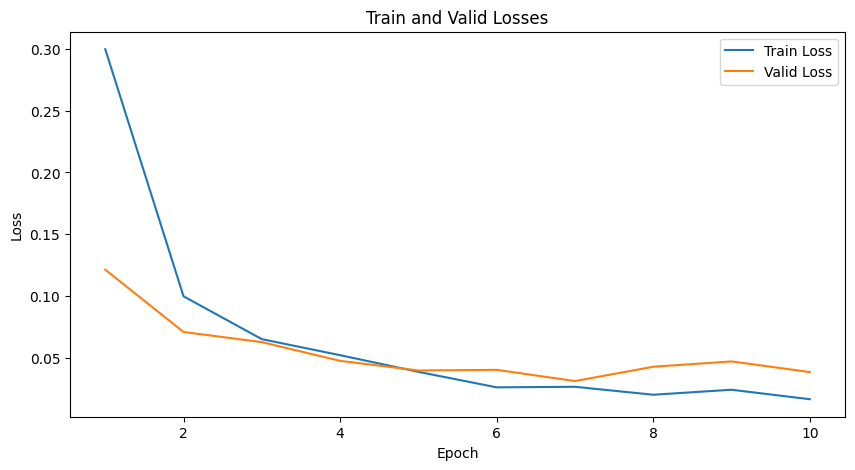

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), eval_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Valid Losses')
plt.legend()
plt.show()

In [26]:
type(train_accs[0])

torch.Tensor

In [28]:
train_accs = [row.tolist() for row in train_accs]
eval_accs = [row.tolist() for row in eval_accs]

In [ ]:
# train_accs = [[value.cpu() for value in row] for row in train_accs]
# eval_accs = [[value.cpu() for value in row] for row in eval_accs]

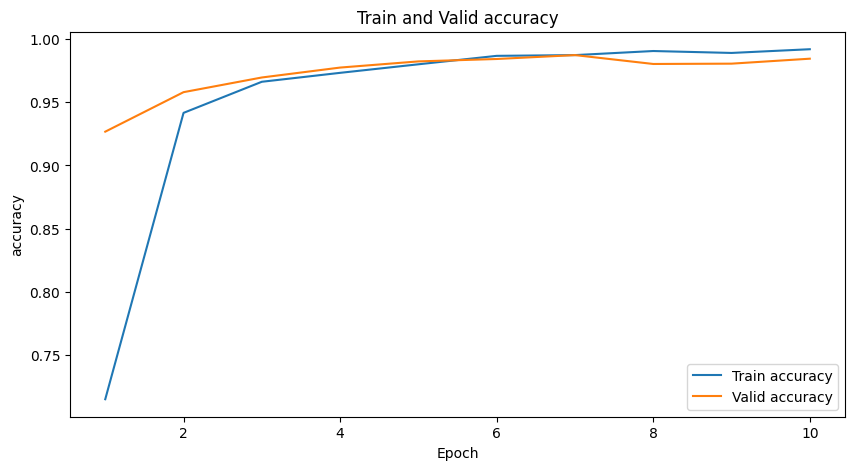

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_accs, label='Train accuracy')
plt.plot(range(1, num_epochs+1), eval_accs, label='Valid accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Train and Valid accuracy')
plt.legend()
plt.show()

Label: glass metal

tensor([-12.8039,  15.1826,   8.3612, -11.6170,  -6.7285,  -9.1453],
       device='cuda:0', grad_fn=<SelectBackward0>)


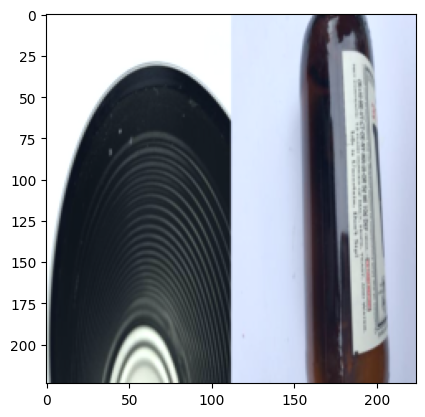

In [30]:
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    show_example(image, prediction)

predict_single(test_dataset[66][0])

### 모델 저장

In [39]:
torch.save(model, '/content/drive/MyDrive/model.pth')

## Test: label 비율 확인

In [40]:
def extract_top_3(label_list, pred_array):
    max_ = pred_array.argsort()[0][-1]
    second_ = pred_array.argsort()[0][-2]
    third_ = pred_array.argsort()[0][-3]

    return [label_list[max_],label_list[second_],label_list[third_]]

In [41]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

Label: metal plastic

tensor([-9.7802, -8.2213,  8.9739, -8.4562, 13.3065, -7.3024], device='cuda:0',
       grad_fn=<SelectBackward0>)


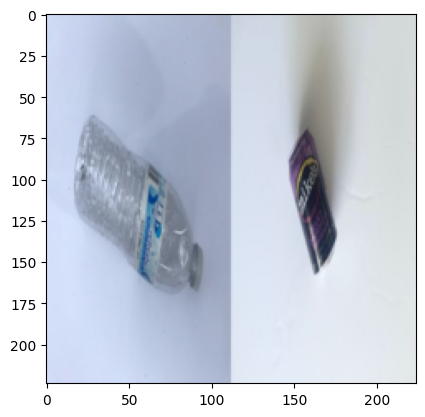

In [42]:
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    show_example(image, prediction)

# validation image 예측해보기
predict_single(valid_dataset[100][0]) # checking out the predictions of some images from the validation dataset.

In [36]:
from PIL import Image
import torchvision.transforms as T

In [37]:
def random_image_prediction(path): #This function is to see the predictions of random images from internet.
    image = Image.open(path)
    image_tensor = T.ToTensor()(image).unsqueeze(0)
    image_tensor = T.Resize([128,128])(image_tensor)
    image_tensor = T.Normalize(*imagenet_stats)(image_tensor)
    #print(image_tensor.shape)
    img = to_device(image_tensor, device)
    preds = model(img)
    prediction = preds[0]
    print("Prediction:")
    print("Tensor: ", prediction)
    print()
    print("Label:", decode_target(prediction))
    plt.imshow(image)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Prediction:
Tensor:  tensor([-0.9454, -2.4610, -1.8076, -2.8645,  3.5596,  3.7416], device='cuda:0',
       grad_fn=<SelectBackward0>)

Label: plastic trash


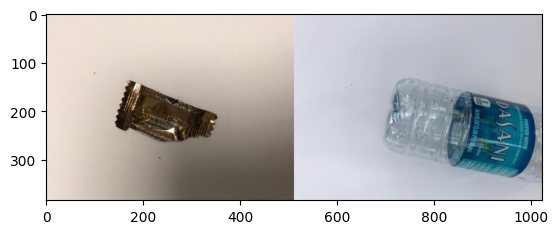

In [38]:
random_image_prediction('/content/drive/MyDrive/random_image.jpg')